<img src="./images/DLI_Header.png" style="width: 400px;">

# 사전 트레이닝된 모델

딥러닝 과제를 해결하기 위해 크고 주석이 제대로 달린 데이터세트를 보유해야 하는 경우가 많기는 하지만, 즉시 무료로 사용 가능한 사전 트레이닝된 모델이 많이 있습니다. 자체적인 딥러닝 프로젝트에 착수하기로 마음먹었다면 먼저 목표를 달성하는 데 도움이 될 수 있는 기존 모델을 온라인에서 찾아보는 게 좋습니다. 이용 가능한 모델을 살펴볼 수 있는 좋은 장소는 [NGC](https://ngc.nvidia.com/catalog/models)입니다. GitHub에서 호스팅되는 모델도 많이 있으며, Google 검색을 통해 찾아볼 수 있습니다. 

## 목표

* Keras를 사용하여 아주 잘 사전 트레이닝된 모델 로드
* 자체 이미지를 사전 처리하여 사전 트레이닝된 모델로 작업
* 사전 트레이닝된 모델을 사용하여 자체 이미지에 대한 정확한 추론 수행

## 개구멍 자동문

이 섹션에서는 다른 동물이 아닌 오직 개만 출입이 가능한 개구멍을 만들어 보겠습니다. 고양이는 내부에 있게 하고, 다른 동물은 원래 있던 외부에 있도록 할 수 있습니다. 지금까지 다룬 기술을 사용하려면 다수의 개와 다른 동물들의 사진으로 이루어진 매우 큰 데이터세트가 필요합니다. 다행히 다수의 동물을 포함한 거대한 데이터세트에 대해 트레이닝된 바로 사용 가능한 모델이 있습니다. 

[ImageNet 챌린지](https://en.wikipedia.org/wiki/ImageNet#History_of_the_ImageNet_challenge)에서는 이미지 분류에 사용 가능한 다수의 첨단 모델이 만들어졌습니다. 이러한 모델은 수백만 개의 이미지에 대해 트레이닝되었으며 이미지를 1,000가지 범주로 정확하게 분류할 수 있습니다. 이러한 범주 중 다수는 개와 고양이 종을 비롯한 동물들입니다. 이는 우리가 만들 개구멍을 위한 완벽한 모델입니다.

## 모델 로드

먼저 모델을 다운로드하겠습니다. 트레이닝된 ImageNet 모델은 Keras 라이브러리 내에서 바로 다운로드할 수 있습니다. 이용 가능한 모델과 세부 정보는 [여기](https://keras.io/api/applications/#available-models)에서 확인할 수 있습니다. 이 중 어떠한 모델도 이 연습에 사용 가능합니다. 일반적으로 사용되는 [VGG16](https://keras.io/api/applications/vgg/)이라는 모델을 선택하겠습니다.

In [1]:
from tensorflow.keras.applications import VGG16
# from tensorflow.keras.applications import MobileNetV2
  
# load the VGG16 network *pre-trained* on the ImageNet dataset
model = VGG16(weights="imagenet")
# model = MobileNetV2(weights="imagenet")


2023-01-29 16:46:49.268737: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# model save
model.save('models/trans_model')

2023-01-28 23:52:54.886582: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: models/trans_model/assets


In [2]:
# model load
from tensorflow.keras.models import load_model
model = load_model('models/trans_model', compile=True) # complie : Boolean, whether to compile the model after loading.

모델이 로드되었으니 모델을 살펴보겠습니다. 수화 연습에서 봤던 컨볼루셔널 모델과 매우 흡사합니다. 첫 번째 레이어(입력 레이어)과 마지막 레이어(출력 레이어)에 주목하십시오. 이전 연습의 경우처럼 이미지가 모델이 예상하는 입력 차원와 일치하도록 해야 합니다. 또한 마지막 출력 레이어에서 모델이 무엇을 반환할지를 파악하는 것도 중요합니다.

In [3]:
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### 입력 차원
모델이 224x224픽셀의 3색 채널에 해당하는 (224, 224, 3) 모양의 이미지를 예상하고 있음을 확인할 수 있습니다. 지난 연습에서 배웠던 것처럼 Keras 모델은 예측을 위해 한 번에 2개 이상의 이미지를 허용할 수 있습니다. 한 개의 이미지만 전달하면 모양은 (1, 224, 224, 3)이 됩니다. 예측을 위해 이미지를 모델에 전달할 때에는 이러한 차원과 일치하는지 확인해야 합니다. 

### 출력 차원
모델이 1000개의 출력값을 반환하는 것을 확인할 수 있습니다. 첫 번째 연습에서는 모델의 출력값이  10가지 숫자에 해당하는 10이었습니다. 두 번째 연습에서는 출력값이 수화 알파벳의 문자 24개에 해당하는 24였습니다. 여기서는 이미지가1,000가지의 범주를 가지고 있습니다. 전체 ImageNet 데이터세트에는 20,000개 이상의 범주가 있지만 경진대회와 사전 트레이닝된 모델(Pre-trained model)에서는 이러한 범주 중 1,000개의 하위 세트만 사용합니다.[여기](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a)에서 이러한 모든 가능한 범주를 살펴볼 수 있습니다. 

범주 중 다수는 개와 고양이 종을 비롯한 동물들입니다. 개 범주는 151-268, 고양이 범주는 281-285에 해당합니다. 이러한 범주를 사용하여 어떤 종의 동물들이 개구멍에 출입할 수 있는지 확인할 수 있습니다.

## 이미지 로드
먼저 이전 연습에서 했던 것처럼 이미지를 로드하여 표시하겠습니다.

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def show_image(image_path):
    image = mpimg.imread(image_path)
    print(image.shape)
    plt.imshow(image)

(1200, 1800, 3)


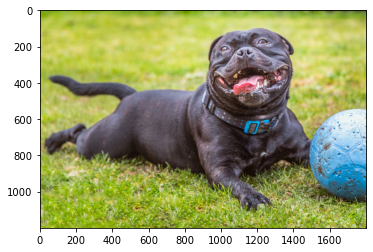

In [5]:
show_image("data/doggy_door_data/happy_dog.jpg")

## 이미지 사전 처리

다음으로는 모델에 보낼 수 있도록 이미지를 사전 처리해야 합니다. 지난 연습에서 수화 이미지에 대한 예측을 수행했을 때 했던 것처럼 하면 됩니다. 이 경우에는 이미지의 마지막 모양이 (1, 224, 224, 3)이 되어야 함을 기억하세요.

Keras로 모델을 바로 로드하는 경우에는 [`preprocess_input` 메서드](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input)를 활용할 수도 있습니다. 특정 모델과 연관되어 있는 이러한 메서드를 사용하면 사용자가 모델이 원래 트레이닝되었던 이미지의 품질에 맞게 자체 이미지를 사전 처리할 수 있습니다. 새로운 ASL 이미지로 추론을 수행할 때는 이를 직접 해야 했습니다.

In [17]:
from tensorflow.keras.preprocessing import image as image_utils
from tensorflow.keras.applications.vgg16 import preprocess_input

# https://keras.io/api/preprocessing/image/

def load_and_process_image(image_path):
    # Print image's original shape, for reference
    print('Original image shape: ', mpimg.imread(image_path).shape)
    
    # Load in the image with a target size of (224, 224)
    image = image_utils.load_img(image_path, target_size=(224, 224))
    print('image = ', image)  # PIL object type
    
    # Convert the image from a PIL format to a numpy array
    image = image_utils.img_to_array(image)  # return a 3D numpy array
    print('image = ', image.shape)  # (224, 224, 3)
    # print(image)
    
    # Add a dimension for number of images, in our case 1
    image = image.reshape(1,224,224,3)
    
    # Preprocess image to align with original ImageNet dataset
    image = preprocess_input(image)
    
    # Print image's shape after processing
    print('Processed image shape: ', image.shape)  # 1
    return image

In [18]:
processed_image = load_and_process_image("data/doggy_door_data/brown_bear.jpg")

Original image shape:  (2592, 3456, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B3DE59B90>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)


## 예측 수행

이미지가 올바른 형식으로 변환되었으니 이제 모델에 전달하여 예측을 얻을 수 있습니다. 여기서는 엘리먼트 1,000개의 어레이 출력을 예상하고 있으므로 읽기가 쉽지 않을 것입니다. 다행히, Keras로 바로 로드된 모델에는 예측 어레이를 좀 더 읽기 수월한 형식으로 변환해주는 또 다른 유용한 메서드가 있습니다. 

다음 함수를 작성하여 예측을 구현하십시오.

In [23]:
from tensorflow.keras.applications.vgg16 import decode_predictions
import numpy as np
    
def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    print('prediction = ', predictions)
    print('argmax = ', np.argmax(predictions))
    
    # Print predictions in readable form
    print('shape: ',  predictions.shape)
    print('Predicted:', decode_predictions(predictions, top=3))

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B41067DD0>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
prediction =  [[3.37335403e-11 2.09093055e-11 1.41375939e-10 3.54905376e-11
  2.05150931e-11 3.26421425e-11 1.56557458e-11 2.83706409e-11
  1.62500534e-11 2.09208961e-09 8.83162738e-13 1.70469385e-11
  1.77305338e-12 5.83963162e-13 2.92065851e-11 8.43409891e-12
  2.17662498e-12 1.87054712e-12 6.07281794e-11 5.07699622e-13
  3.57807839e-10 2.86052793e-10 6.52734542e-08 4.66417627e-10
  2.60971557e-11 9.57478541e-12 4.56749152e-11 4.82024975e-11
  1.85294510e-12 2.77199912e-11 4.19326639e-12 4.60356709e-12
  3.48668802e-11 1.42140841e-10 3.67945362e-11 2.89843826e-11
  2.84264473e-10 3.22897807e-12 2.94975763e-12 4.59997665e-12
  3.08171175e-12 5.75815058e-13 2.67771851e-12 4.12683126e-12
  2.22308023e-12 3.38073363e-12 5.64065548e-12 1.23494982e-11
  2.24374699e-10 3.37594463e-09 8.24578739e-11 2.7

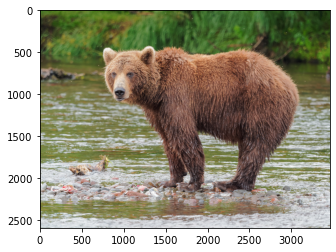

In [24]:
readable_prediction("data/doggy_door_data/brown_bear.jpg")

### 솔루션

아래의 '...'를 클릭하면 솔루션이 표시됩니다.

```python
from tensorflow.keras.applications.vgg16 import decode_predictions

def readable_prediction(image_path):
    # Show image
    show_image(image_path)
    # Load and pre-process image
    image = load_and_process_image(image_path)
    # Make predictions
    predictions = model.predict(image)
    # Print predictions in readable form
    print('Predicted:', decode_predictions(predictions, top=3))
```

몇 개의 동물에 사용하여 결과를 확인해 보십시오! 또한 자유롭게 자체 이미지를 업로드하고 분류하여 성능을 확인해 보십시오.

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B410A1C10>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
prediction =  [[2.35359309e-07 7.19832105e-09 2.34530706e-09 7.79847209e-09
  3.68652238e-08 3.75998344e-09 3.22770499e-09 6.80152971e-06
  5.68979231e-05 1.59244948e-07 2.04516954e-08 1.32925393e-07
  6.14304696e-08 9.07924118e-08 5.98389124e-06 1.72595179e-07
  1.38207099e-07 2.71798763e-05 1.68224025e-04 4.21847623e-08
  2.37340586e-07 8.63832597e-08 9.53398782e-09 6.51688752e-05
  3.14475585e-07 1.02998019e-05 1.59395131e-06 1.32140741e-07
  3.57906356e-05 2.87833745e-06 1.62682918e-05 1.90979245e-06
  4.42751161e-06 2.37616966e-08 4.23047823e-06 1.72937416e-05
  6.24535278e-06 2.23648181e-06 2.48937226e-07 7.47699378e-05
  4.66033242e-07 3.25587280e-07 8.37470509e-07 1.58187518e-07
  1.18182061e-06 1.09020175e-06 1.15711055e-05 9.32905493e-07
  2.70393480e-06 8.54486757e-07 3.45787407e-06 7.6

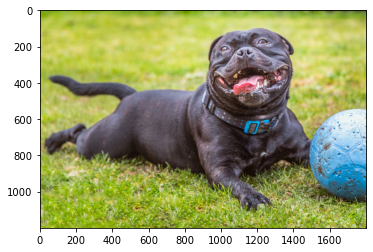

In [25]:
readable_prediction("data/doggy_door_data/happy_dog.jpg")

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B3DC0EE10>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
prediction =  [[3.37335403e-11 2.09093055e-11 1.41375939e-10 3.54905376e-11
  2.05150931e-11 3.26421425e-11 1.56557458e-11 2.83706409e-11
  1.62500534e-11 2.09208961e-09 8.83162738e-13 1.70469385e-11
  1.77305338e-12 5.83963162e-13 2.92065851e-11 8.43409891e-12
  2.17662498e-12 1.87054712e-12 6.07281794e-11 5.07699622e-13
  3.57807839e-10 2.86052793e-10 6.52734542e-08 4.66417627e-10
  2.60971557e-11 9.57478541e-12 4.56749152e-11 4.82024975e-11
  1.85294510e-12 2.77199912e-11 4.19326639e-12 4.60356709e-12
  3.48668802e-11 1.42140841e-10 3.67945362e-11 2.89843826e-11
  2.84264473e-10 3.22897807e-12 2.94975763e-12 4.59997665e-12
  3.08171175e-12 5.75815058e-13 2.67771851e-12 4.12683126e-12
  2.22308023e-12 3.38073363e-12 5.64065548e-12 1.23494982e-11
  2.24374699e-10 3.37594463e-09 8.24578739e-11 2.7

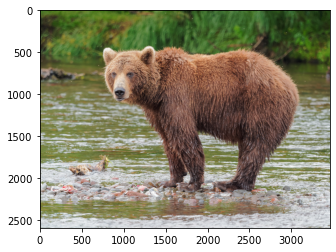

In [26]:
readable_prediction("data/doggy_door_data/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B3E287210>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
prediction =  [[1.46012121e-06 3.10012656e-05 7.12032545e-07 6.16946068e-07
  1.04431841e-07 2.15935620e-06 3.36516983e-08 3.70267771e-05
  7.69998733e-05 4.57013869e-07 3.77005199e-06 5.62880132e-07
  9.79253582e-06 2.51220558e-06 3.42265679e-07 1.48442723e-05
  3.72719740e-07 1.67135408e-06 2.04115949e-07 3.04517584e-07
  3.36670269e-07 2.72075312e-07 6.59330937e-08 1.43113780e-07
  1.37341738e-06 1.35963930e-07 1.31094657e-06 1.43288798e-06
  2.47523229e-08 1.22790789e-05 5.93663799e-07 5.99647535e-07
  3.46622357e-07 2.96165297e-07 3.95278548e-08 2.40896696e-07
  1.20250479e-06 4.73741602e-06 1.49106017e-05 2.05975612e-05
  1.90457595e-05 4.76221658e-06 1.95482826e-05 2.10159924e-05
  1.74148972e-05 1.67588689e-06 5.45298499e-05 2.66074749e-05
  5.76706543e-06 1.67980090e-06 1.86698924e-06 4.1

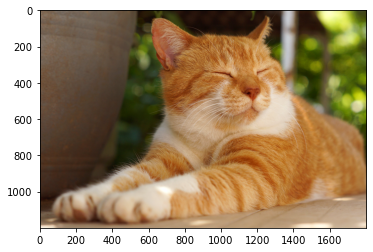

In [27]:
readable_prediction("data/doggy_door_data/sleepy_cat.jpg")

## 개만

모델로 예측을 수행 중이므로 이제 범주를 사용하여 개만 출입을 허용하고 고양이는 내부에 있게 할 수 있습니다. 개는 범주 151 ~ 268이고, 고양이는 범주 281 ~ 285임을 기억하세요. [np.argmax](https://numpy.org/doc/stable/reference/generated/numpy.argmax.html) 함수는 예측 어레이의 어떤 엘리먼트가 상위 범주인지 찾아낼 수 있습니다.

In [28]:
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    if 151 <= np.argmax(preds) <= 268:
        print("Doggy come on in!")
    elif 281 <= np.argmax(preds) <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")

### 솔루션

아래의 '...'를 클릭하면 솔루션이 표시됩니다.

```python
import numpy as np

def doggy_door(image_path):
    show_image(image_path)
    image = load_and_process_image(image_path)
    preds = model.predict(image)
    if 151 <= np.argmax(preds) <= 268:
        print("Doggy come on in!")
    elif 281 <= np.argmax(preds) <= 285:
        print("Kitty stay inside!")
    else:
        print("You're not a dog! Stay outside!")
```

(2592, 3456, 3)
Original image shape:  (2592, 3456, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B3E23E690>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
You're not a dog! Stay outside!


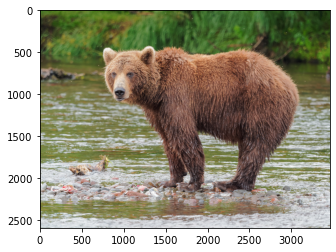

In [29]:
doggy_door("data/doggy_door_data/brown_bear.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x7F8B3E23E850>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Doggy come on in!


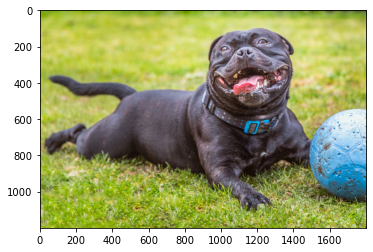

In [30]:
doggy_door("data/doggy_door_data/happy_dog.jpg")

(1200, 1800, 3)
Original image shape:  (1200, 1800, 3)
image =  <PIL.Image.Image image mode=RGB size=224x224 at 0x28419F92F60>
image =  (224, 224, 3)
Processed image shape:  (1, 224, 224, 3)
Kitty stay inside!


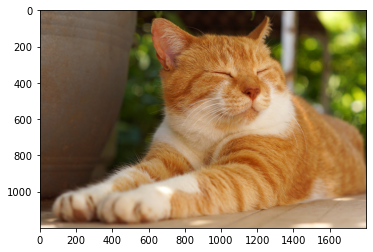

In [18]:
doggy_door("data/doggy_door_data/sleepy_cat.jpg")

## 요약

잘하셨습니다! 사전 트레이닝된 강력한 모델을 사용하여 불과 몇 행의 코드로 작동 가능한 개구멍을 만들었습니다. 많은 사전 작업 없이도 딥러닝을 활용할 수 있다는 점에 즐거워하시길 바랍니다. 가장 좋은 점은 딥러닝 커뮤니티가 발전함에 따라 더 많은 모델을 각자의 프로젝트에 사용할 수 있게 될 것이라는 것입니다.

### 메모리 지우기
넘어가기 전에 다음 셀을 실행하여 GPU 메모리를 지워주시기 바랍니다.

In [28]:
import IPython
app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

## 다음

사전 트레이닝된 모델 사용은 매우 강력한 기술이지만 간혹 데이터에 완벽하게 들어맞지 않을 수도 있습니다. 다음 섹션에서는 또 다른 강력한 기술인 *전이 학습(Transfer Learning)*에 대해 알아보겠습니다. 이 기술은 사전 트레이닝된 모델을 맞춤화하여 데이터에 대한 적절한 예측을 수행할 수 있게 해줍니다.

이어서 다음 섹션인 [*사전 트레이닝된 모델*](./05b_presidential_doggy_door.ipynb)을 계속 진행해 주십시오.